In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import random as rn
from scipy.optimize import root_scalar
from multiprocessing import Pool
import pandas as pd


In [2]:
#%% FORMATO GRRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None):
    # Configuración personalizada de la gráfica
    if ax is None:
        ax = plt.gca()

    # Fuente personalizada
    fuente = 'serif'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    # Cambiar configuración de fuentes matemáticas
    plt.rcParams['mathtext.fontset'] = 'cm'  # Cambiar a Computer Modern (fuente predeterminada de LaTeX)
    plt.rcParams['mathtext.rm'] = 'serif'  # Usar fuente romana no itálica para texto matemático
    plt.rcParams['mathtext.default'] = 'rm' # Establecer que todo el texto matemático sea romano no itálico

    # Locator y sublocadores
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # Configurar los ticks
    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Establecer el formato del número en el eje x y y dependiendo de los valores de decimalx y decimaly
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    # Ajustar el tamaño de la fuente de las leyendas cuando se añaden
    if ax.get_legend() is not None:
        ax.legend(fontsize=14)

    # También puedes especificar la leyenda directamente al llamarla:
    font = font_manager.FontProperties(family='serif', style='normal', size=14)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(handles, labels, edgecolor='1', framealpha=0.5 , prop=font)  # Establecer tamaño de la fuente en 14 para la leyenda


In [3]:
T_m =28.8 #tiempo de semivida del estroncio 90  en años 

años_a_segundos = (365*30*24*60*60)

tau = (T_m/np.log(2)) #*años_a_segundos #tiempo de vida media

gamma = 1/tau #constante de decaimiento

delta_t= 0.1*tau #discretizacion del tiempo en fracciones de tau para poder capturar los eventos de decaimiento

tf= 4*tau # tiempo suficiente para que la mayoria de los nucleos hayan decaido

N0=[10**2, 10**3, 10**6, 10**8] #cantidad de nucleos en el experimento 

np.random.seed(2024)

def P(gamma, t): #probabilidad de que un nucleo no decaiga desde el instante t=0 hasta el intante t
 return np.exp(-gamma*t)*gamma


def F(gamma, t):
    return 1 - np.exp(-gamma*t)


def F_inverse(r, gamma):  # Función inversa de la acumulativa
    return -np.log(1 - r) / gamma

def modelo_exp(N0, F_inverse, gamma, tf, delta_t):
    """
    Realiza la simulación exponencial para varios valores iniciales de N0 y genera una matriz de resultados.

    Parámetros:
        N0 (list): Lista de valores iniciales de núcleos.
        F_inverse (function): Función inversa acumulativa de probabilidad.
        gamma (float): Constante de decaimiento.
        tf (float): Tiempo final de la simulación.
        delta_t (float): Paso de tiempo para la simulación.

    Retorna:
        resultados (list): Lista con los tiempos, núcleos restantes, decaimientos y valor inicial N para cada simulación.
    """
    resultados = []

    for N in N0:
        t = 0
        tiempos = []
        N_restantes = []
        decaimientos = []
        N_exp=N
        # Generar valores aleatorios y calcular tiempos de decaimiento
        r_values = np.random.random(N)
        t_decay = F_inverse(r_values, gamma)
        t_decay = t_decay[t_decay <= tf]

        while t <= tf and N_exp > 0:
            # Calcular decaimientos en el intervalo actual
            decaidos = np.sum((t <= t_decay) & (t_decay < t + delta_t))
            N_exp -= decaidos
            
            # Registrar resultados
            tiempos.append(t)
            N_restantes.append(N_exp)
            decaimientos.append(decaidos)
            
            t += delta_t

        resultados.append((tiempos, N_restantes, decaimientos, N))
    
    return resultados

# Ejemplo de uso:
# resultados = modelo_exp(N0, F_inverse, gamma, tf, delta_t)


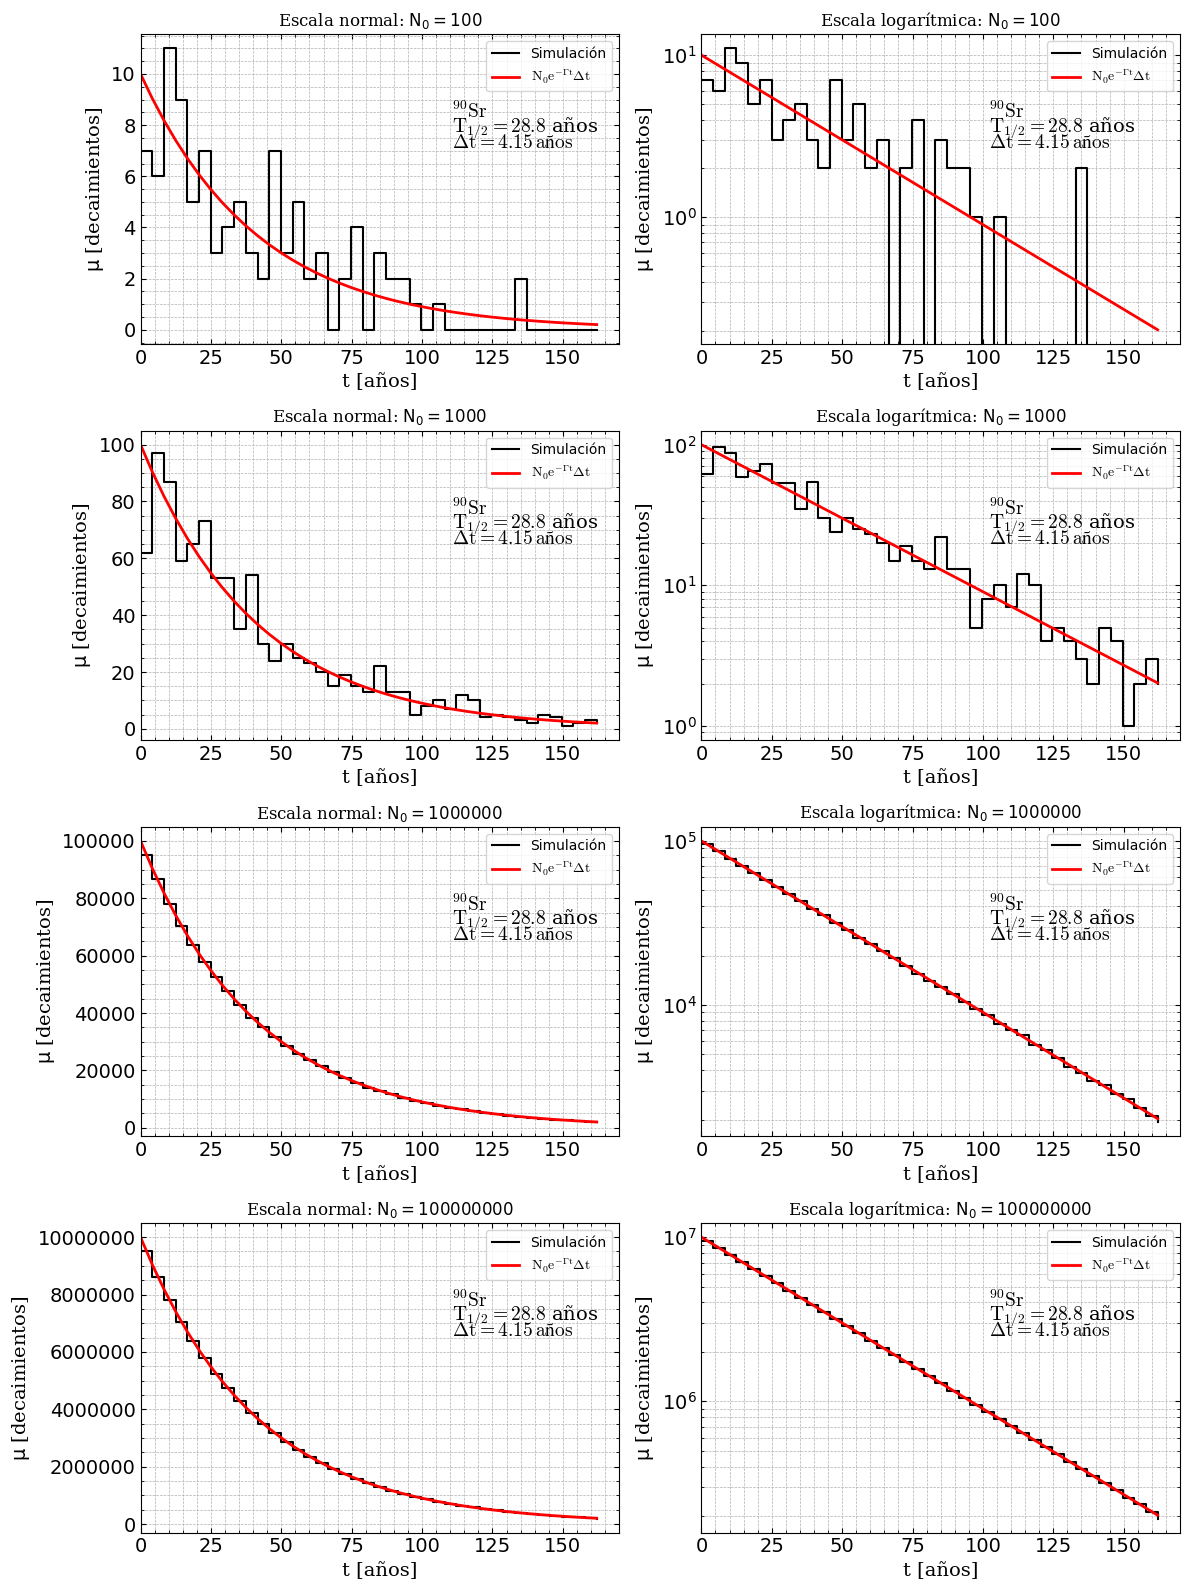

In [4]:
# Generar los resultados usando modelo_exp
resultados_exp = modelo_exp(N0, F_inverse, gamma, tf, delta_t)

# --- Graficación ---
fig, axs = plt.subplots(len(N0), 2, figsize=(12, 16))

for i, (tiempos, N_restantes, decaimientos, N) in enumerate(resultados_exp):
    # Crear t_decay a partir de los tiempos y decaimientos
    t_decay = []
    for idx, num_decaidos in enumerate(decaimientos):
        t_decay.extend([tiempos[idx]] * num_decaidos)
    t_decay = np.array(t_decay)
    t_decay = t_decay[t_decay <= tf]

    # Crear bins con el intervalo temporal delta_t
    bins = np.arange(0, tf + delta_t, delta_t)

    # Crear el histograma de tiempos de decaimiento
    hist, bin_edges = np.histogram(t_decay, bins=bins)
    # Densidad de probabilidad teórica P(t)
    t_values = np.arange(0, tf, delta_t)
    P_theoretical = P(gamma, t_values)

    # Escalar por N_0 y delta_t
    P_scaled = N * P_theoretical * delta_t

    # Gráfica de escala normal
    ax = axs[i, 0]
    ax.step(bin_edges[:-1], hist, where='post', color='black', label="Simulación")
    ax.plot(bins[:-1], P_scaled, 'r-', linewidth=2, label=r"$N_0 e^{-\Gamma t} \Delta t$")
    formato_grafico(ax, 0, 0)
    ax.set_xlim([0, 170])
    ax.set_xlabel("t [años]")
    ax.set_ylabel(r"$\mu$ [decaimientos]")
    ax.set_title(f"Escala normal: $N_0 = {N}$")

    # Textos explicativos
    ax.text(0.65, 0.75, r"$^{90}Sr$", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.text(0.65, 0.7, rf"$T_{{1/2}} = {T_m}$ años", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.text(0.65, 0.65, rf"$\Delta t = {delta_t:.2f} \, \text{{años}}$", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Gráfica de escala Logarítmica
    ax = axs[i, 1]
    ax.step(bin_edges[:-1], hist, where='post', color='black', label="Simulación")
    ax.plot(bins[:-1], P_scaled, 'r-', linewidth=2, label=r"$N_0 e^{-\Gamma t} \Delta t$")
    formato_grafico(ax, 0, 0)
    ax.set_yscale('log')  # Cambiar a escala logarítmica
    ax.set_xlim([0, 170])
    ax.set_xlabel("t [años]")
    ax.set_ylabel(r"$\mu$ [decaimientos]")
    ax.set_title(f"Escala logarítmica: $N_0 = {N}$")

    # Textos explicativos
    ax.text(0.6, 0.75, r"$^{90}Sr$", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.text(0.6, 0.7, rf"$T_{{1/2}} = {T_m}$ años", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.text(0.6, 0.65, rf"$\Delta t = {delta_t:.2f} \, \text{{años}}$", transform=ax.transAxes, ha='left', va='center', fontsize=14, family='serif')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar el espaciado
plt.tight_layout()
plt.savefig('nombre_del_archivo.png', dpi=500, bbox_inches='tight')
plt.show()


# Verificación detallada de \( P_B(x) \)

La densidad de probabilidad binomial está dada por:

$$
P_B(x) = \frac{N!}{x! (N - x)!} p^x (1-p)^{N-x}.
$$

Para el caso en que \( N = 1 \), la ecuación se simplifica debido a que \( 1! = 1 \). Por lo tanto:

$$
P_B(x) = \frac{1}{x! (1-x)!} p^x (1-p)^{1-x}.
$$

## Evaluación para \( x = 0 \)

Cuando \( x = 0 \), sustituimos en la expresión de \( P_B(x) \):

$$
P_B(0) = \frac{1}{0! (1-0)!} p^0 (1-p)^1.
$$

Sabemos que:

$$
0! = 1, \quad (1-0)! = 1, \quad \text{y } p^0 = 1.
$$

Entonces:

$$
P_B(0) = \frac{1}{1 \cdot 1} \cdot 1 \cdot (1-p) = 1-p.
$$

## Evaluación para \( x = 1 \)

Cuando \( x = 1 \), sustituimos en la expresión de \( P_B(x) \):

$$
P_B(1) = \frac{1}{1! (1-1)!} p^1 (1-p)^0.
$$

Sabemos que:

$$
1! = 1, \quad (1-1)! = 0! = 1, \quad \text{y } (1-p)^0 = 1.
$$

Entonces:

$$
P_B(1) = \frac{1}{1 \cdot 1} \cdot p \cdot 1 = p.
$$

## Conclusión

Por lo tanto, los valores de \( P_B(x) \) son:

$$
P_B(x) =
\begin{cases}
1-p, & \text{si } x = 0, \\
p, & \text{si } x = 1.
\end{cases}
$$

Esto verifica la expresión dada.



In [5]:
def f_binomial(p, x):
    if x == 1:
        return p
    elif x == 0:
        return 1 - p
    else:
        raise ValueError("x debe ser 0 o 1")

def F_binomial(x, p,):
    if x < 0:
        return 0
    elif x == 0:
        return 1 - p
    else:
        return 1

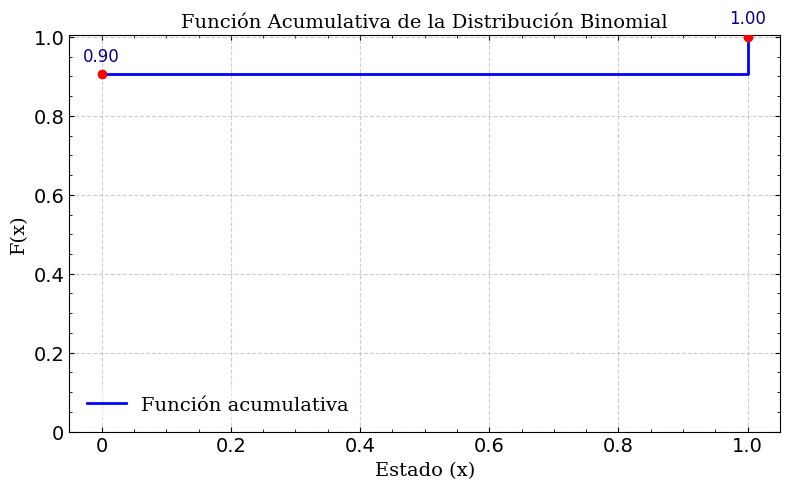

In [22]:
# Probabilidad de decaer en el intervalo delta_t
p = F(gamma, delta_t)
x_values = [0, 1]  # Posibles valores de x (no decaer, decaer)
F_values = [1 - p, 1]  # Valores acumulativos

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 5))

# Graficar la función acumulativa
ax.step(x_values, F_values, where='post', color='blue', linewidth=2, label="Función acumulativa")
ax.scatter(x_values, F_values, color='red', zorder=5)  # Marcar los puntos exactos

# Añadir anotaciones para los valores de la función
for i, (x, y) in enumerate(zip(x_values, F_values)):
    ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='darkblue')

# Ajustar etiquetas del eje X
ax.set_xticks(x_values)  # Solo mostrar etiquetas para 0 y 1
ax.set_xticklabels(["No Decaer (x=0)", "Decaer (x=1)"], fontsize=12)

# Configuración del eje Y
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(labelsize=12)
ax.set_xlabel("Estado (x)", fontsize=14)
ax.set_ylabel("F(x)", fontsize=14)
ax.set_title("Función Acumulativa de la Distribución Binomial", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.6)

# Leyenda para la función acumulativa
ax.legend(fontsize=12, loc="lower right")

# Aplicar formato personalizado
formato_grafico(ax,1,1)

# Ajustar diseño
plt.tight_layout()
plt.savefig('Función Acumulativa de la Distribución Binomial', dpi=500, bbox_inches='tight')
plt.show()

In [9]:
def simulacion_binomial(N0, tf, gamma, delta_t, F):
    """
    Realiza la simulación binomial para varios valores iniciales de N0.

    Parámetros:
        N0 (list): Lista de valores iniciales de núcleos.
        tf (float): Tiempo final de la simulación.
        gamma (float): Constante de decaimiento.
        delta_t (float): Paso de tiempo para la simulación.
        F (function): Función acumulativa de probabilidad.

    Retorna:
        resultados_binomial (list): Lista con los tiempos, núcleos restantes y valor inicial N para cada simulación.
    """
    resultados_binomial = []

    for N in N0:  # Iterar sobre cada valor inicial de N0
        t = 0
        tiempos = []
        N_restantes = []
        decaimientos = []
        N_bin=N
        while t <= tf and N_bin > 0:
            p = F(gamma, delta_t)
            r_values = np.random.random(N_bin)
            decaidos = np.sum(r_values < p)  # Simulación Monte Carlo para decaimiento binomial
            N_bin -= decaidos
            tiempos.append(t)
            N_restantes.append(N_bin)
            decaimientos.append(decaidos)
            t += delta_t

        resultados_binomial.append((tiempos, N_restantes, decaimientos,N))
    
    return resultados_binomial




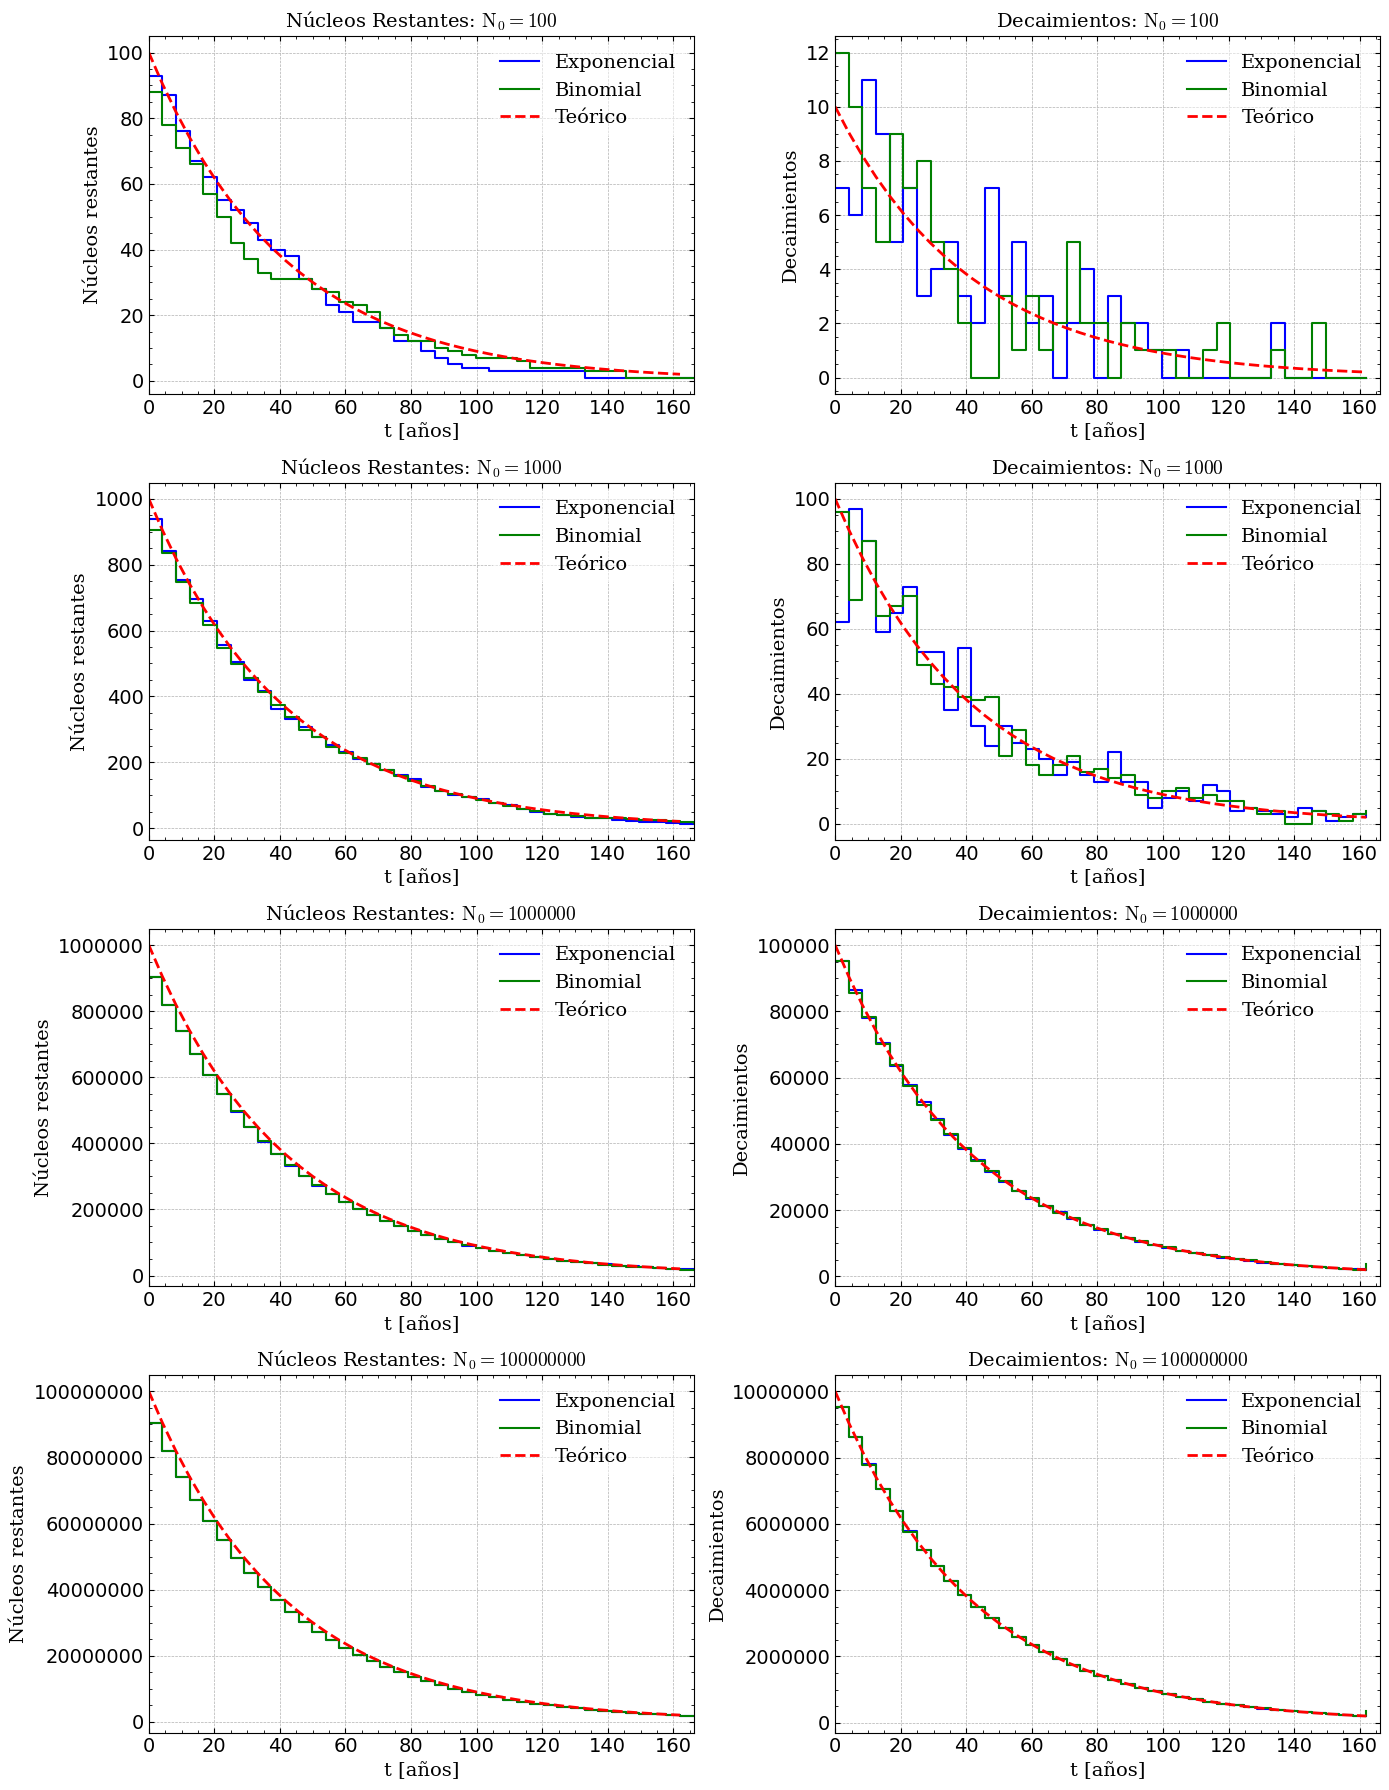

In [20]:
resultados_binomial=simulacion_binomial(N0, tf, gamma, delta_t, F)
# --- Graficación comparativa ---
fig, axs = plt.subplots(len(N0), 2, figsize=(14, 18))

# Iterar sobre las simulaciones de ambos modelos
for idx, ((tiempos_exp, N_restantes_exp, decaimientos_exp, N_exp),
          (tiempos_bin, N_restantes_bin, decaimientos_bin, N_bin)) in enumerate(zip(resultados_exp, resultados_binomial)):

    # Crear t_decay para el modelo exponencial
    t_decay_exp = []
    for t_idx in range(min(len(tiempos_exp), len(decaimientos_exp))):  # Asegurar longitud válida
        num_decaidos = decaimientos_exp[t_idx]
        t_decay_exp.extend([tiempos_exp[t_idx]] * num_decaidos)
    t_decay_exp = np.array(t_decay_exp)
    t_decay_exp = t_decay_exp[t_decay_exp <= tf]

    # Crear t_decay para el modelo binomial
    t_decay_bin = []
    for t_idx in range(min(len(tiempos_bin), len(decaimientos_bin))):  # Asegurar longitud válida
        num_decaidos = decaimientos_bin[t_idx]
        t_decay_bin.extend([tiempos_bin[t_idx]] * num_decaidos)
    t_decay_bin = np.array(t_decay_bin)
    t_decay_bin = t_decay_bin[t_decay_bin <= tf]

    # Crear bins para histogramas
    bins = np.arange(0, tf + delta_t, delta_t)

    # Histograma y función teórica
    hist_exp, bin_edges = np.histogram(t_decay_exp, bins=bins)
    hist_bin, bin_edges = np.histogram(t_decay_bin, bins=bins)
    t_values = np.arange(0, tf, delta_t)
    P_theoretical = P(gamma, t_values)
    P_scaled = N_exp * P_theoretical * delta_t
    F_theoretical = F(gamma, t_values)
    F_scaled = N_exp * F_theoretical * delta_t

    # Subplot núcleos restantes
    ax = axs[idx, 0]
    ax.step(tiempos_exp, N_restantes_exp, where='post', color='blue', label="Exponencial")
    ax.step(tiempos_bin, N_restantes_bin, where='post', color='green', label="Binomial")
    ax.plot(t_values, N_exp * np.exp(-gamma * t_values), 'r--', linewidth=2, label="Teórico")

    ax.set_xlim(0, tf)
    ax.set_xlabel("t [años]")
    ax.set_ylabel("Núcleos restantes")
    ax.set_title(f"Núcleos Restantes: $N_0 = {N_exp}$")
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5)
    formato_grafico(ax,0,0)
    # Subplot decaimientos
    ax = axs[idx, 1]
    ax.step(bin_edges[:-1], hist_exp, where='post', color='blue', label="Exponencial")
    ax.step(bin_edges[:-1], hist_bin, where='post', color='green', label="Binomial")
    ax.plot(bins[:-1], P_scaled, 'r--', linewidth=2, label="Teórico")

    ax.set_xlim(0, tf)
    ax.set_xlabel("t [años]")
    ax.set_ylabel("Decaimientos")
    ax.set_title(f"Decaimientos: $N_0 = {N_exp}$")
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5)
    formato_grafico(ax,0,0)
# Ajustar el espaciado
plt.tight_layout()
plt.savefig('comparativa_modelos.png', dpi=500, bbox_inches='tight')
plt.show()



In [65]:
# Crear la tabla con los datos de las simulaciones
filas = []
columnas = ["Tiempo [años]", "Núcleos Restantes (Exponencial)", "Núcleos Restantes (Binomial)", "Predicción Teórica", "N0"]

# Recopilar datos para cada simulación y predicción teórica
for idx, (tiempos_exp, N_restantes_exp, N_inicial) in enumerate(resultados):
    tiempos_bin, N_restantes_bin, _ = resultados_binomial[idx]
    for i, t in enumerate(tiempos_exp):
        fila = [
            t,  # Tiempo
            N_restantes_exp[i],  # Núcleos restantes (Exponencial)
            N_restantes_bin[i] if i < len(N_restantes_bin) else None,  # Núcleos restantes (Binomial)
            N_inicial * np.exp(-gamma * t),  # Predicción Teórica
            N_inicial,  # N0
        ]
        filas.append(fila)

# Crear el DataFrame
tabla_resultados = pd.DataFrame(filas, columns=columnas)

# Guardar la tabla en un archivo CSV
tabla_resultados.to_csv("tabla_comparativa_resultados.csv", index=False)

print("Tabla generada y guardada como 'tabla_comparativa_resultados.csv'")




Tabla generada y guardada como 'tabla_comparativa_resultados.csv'


In [14]:
# Verificación de conservación para el modelo exponencial
print("\n--- Verificación del modelo exponencial ---")
for idx, (tiempos_exp, N_restantes_exp, decaimientos_exp, N0_exp) in enumerate(resultados_exp):
    print(f"\nVerificando para N0 = {N0_exp}:")
    for t_idx, (N_restante, num_decaidos) in enumerate(zip(N_restantes_exp, decaimientos_exp)):
        suma = N_restante + sum(decaimientos_exp[:t_idx + 1])  # Núcleos restantes + decaimientos acumulados
        estado = "Correcto" if suma == N0_exp else "Desviación"
        print(f"t = {tiempos_exp[t_idx]:.2f} años: Núcleos restantes = {N_restante}, "
              f"Decaimientos = {sum(decaimientos_exp[:t_idx + 1])}, Suma = {suma} ({estado})")

# Verificación de conservación para el modelo binomial
print("\n--- Verificación del modelo binomial ---")
for idx, (tiempos_bin, N_restantes_bin, decaimientos_bin, N0_bin) in enumerate(resultados_binomial):
    print(f"\nVerificando para N0 = {N0_bin}:")
    for t_idx, (N_restante, num_decaidos) in enumerate(zip(N_restantes_bin, decaimientos_bin)):
        suma = N_restante + sum(decaimientos_bin[:t_idx + 1])  # Núcleos restantes + decaimientos acumulados
        estado = "Correcto" if suma == N0_bin else "Desviación"
        print(f"t = {tiempos_bin[t_idx]:.2f} años: Núcleos restantes = {N_restante}, "
              f"Decaimientos = {sum(decaimientos_bin[:t_idx + 1])}, Suma = {suma} ({estado})")




--- Verificación del modelo exponencial ---

Verificando para N0 = 100:
t = 0.00 años: Núcleos restantes = 93, Decaimientos = 7, Suma = 100 (Correcto)
t = 4.15 años: Núcleos restantes = 87, Decaimientos = 13, Suma = 100 (Correcto)
t = 8.31 años: Núcleos restantes = 76, Decaimientos = 24, Suma = 100 (Correcto)
t = 12.46 años: Núcleos restantes = 67, Decaimientos = 33, Suma = 100 (Correcto)
t = 16.62 años: Núcleos restantes = 62, Decaimientos = 38, Suma = 100 (Correcto)
t = 20.77 años: Núcleos restantes = 55, Decaimientos = 45, Suma = 100 (Correcto)
t = 24.93 años: Núcleos restantes = 52, Decaimientos = 48, Suma = 100 (Correcto)
t = 29.08 años: Núcleos restantes = 48, Decaimientos = 52, Suma = 100 (Correcto)
t = 33.24 años: Núcleos restantes = 43, Decaimientos = 57, Suma = 100 (Correcto)
t = 37.39 años: Núcleos restantes = 40, Decaimientos = 60, Suma = 100 (Correcto)
t = 41.55 años: Núcleos restantes = 38, Decaimientos = 62, Suma = 100 (Correcto)
t = 45.70 años: Núcleos restantes = 31, 